In [1]:
import os
from math import pi
import numpy as np
import random
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
# from qiskit.quantum_info import Statevector
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
# from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import Estimator as Estimator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#from qiskit_algorithms.optimizers import SPSA
#from qiskit_algorithms import utils

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Let's try distinguishing between "versicolor" and "virginica" (because distinguishing them from "setosa" is too trivial), which has class labels `1` and `2`, respectively.

In [2]:
iris = datasets.load_iris()

all_features = iris.data
all_labels = iris.target

all_features = MinMaxScaler().fit_transform(all_features)

class_filter = (all_labels >= 1) # only keep class 1 and class 2
features = all_features[class_filter]
labels = all_labels[class_filter]
labels -= 1 # change class labels from 1, 2 to 0, 1 for convenience

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, shuffle=True, random_state = 123, stratify = labels
)

In [30]:
all_features

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667],
       [0.13888889, 0.41666667, 0.06779661, 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        ],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.38888889, 1.        , 0.08474576, 0.125     ],
       [0.30555556, 0.79166667, 0.05084746, 0.125     ],
       [0.22222222, 0.625     ,

In [3]:
simulator = AerSimulator()
sampler = Sampler.from_backend(simulator)
# estimator = Estimator.from_backend(simulator)
# estimator = Estimator()
pm = generate_preset_pass_manager(backend=simulator, optimization_level=1)

In [4]:
## configuration files for qiskit training

shots = 100

rng = np.random.default_rng()

n_qubits = 4
n_layers = 2
final_rotation_layer = True
n_rots = 2 # number of rotations per qubit per layer
# n_parameters = n_rots * n_qubits * (n_layers + 1) if final_rotation_layer else n_qubits*n_layers*n_rots
n_parameters = 7 #n_rots * n_qubits * (n_layers + 1) + n_qubits if final_rotation_layer else n_qubits*n_layers*n_rots + n_qubits



n_par_per_layer = n_rots * n_qubits

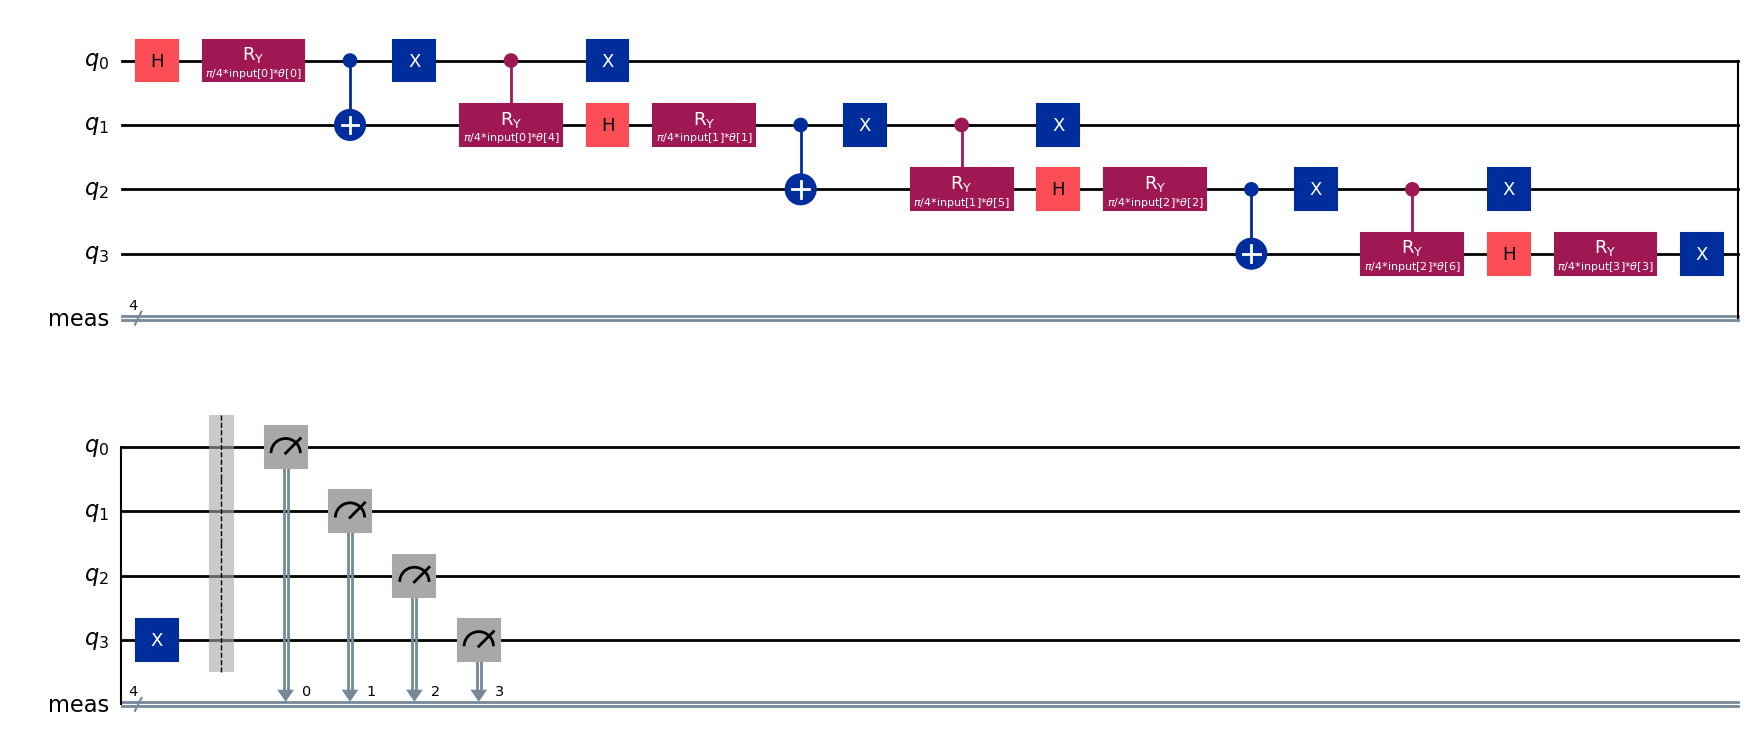

In [19]:
par_inputs = ParameterVector("input", 4)
par_weights = ParameterVector(r"$\theta$", n_parameters)

# Create a new circuit with two qubits
qc_template = QuantumCircuit(n_qubits)

#in qiskit, qubits are automatically initialized to 0
for i in range(n_qubits):
    qc_template.h(i) #add hadamard gate to all lines
    #qc.h(qubit its on)
    #qc_template.rx(par_inputs[i] * par_weights[i], i)
    qc_template.ry(np.pi*0.25*par_inputs[i] * par_weights[i],i) #add ry gate with theta func
    #qc.h(angle, qubit its on)
    if i<n_qubits-1:
        qc_template.cx(i,i+1) #controlled not gate (CNOT) 
        #qc.cx(from, to)
    qc_template.x(i)
    #qc.x(qubit its on)
    if i<n_qubits-1: 
        qc_template.cry(np.pi*0.25*par_inputs[i] * par_weights[4 + i],i,i+1)
        #qc.cry(angle, from, to)
    qc_template.x(i)



qc_template.measure_all()

isa_circ = pm.run(qc_template)

qc_template.draw('mpl')


In [20]:
# let's say we measure one of the qubits as the output
def convert_dic_to_val(dic):
    total_counts = 0
    matching_counts = 0
    for key, val in dic.items():
        total_counts += val
        if key[1] == "1":
            matching_counts += val
    return matching_counts / total_counts


def get_circ_output(params_input, params_weights, isa_circ = isa_circ,
    param_input_holder = par_inputs, param_weight_holder = par_weights, sampler=sampler, shots=shots):
    isa_bind = isa_circ.assign_parameters({param_input_holder: params_input, param_weight_holder: params_weights })
    result = sampler.run([isa_bind], shots=shots).result()
    counts = result[0].data.meas.get_counts()
    prediction = convert_dic_to_val(counts)
    return prediction
    



def get_circ_list_output(params_input_list, params_weights, isa_circ = isa_circ, 
    param_input_holder = par_inputs, param_weight_holder = par_weights, sampler=sampler, shots=shots):
    return np.array([get_circ_output(params_input, params_weights,
                            param_input_holder = par_inputs, param_weight_holder = par_weights, 
                            sampler=sampler, shots=shots)\
            for params_input in params_input_list])

In [21]:
# Binary cross entropy loss
def binary_cross_entropy(y_true, y_pred, eps=1e-10):
    # clip to avoid log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [22]:
# Objective function for optimizer
def objective(params_weights):
    preds = get_circ_list_output(train_features, params_weights)
    loss = binary_cross_entropy(train_labels, preds)
    return loss


In [23]:
loss_log = []
def callback(params_weights):
    # record loss at current step
    current_loss = objective(params_weights)
    loss_log.append(current_loss)
    print(f"Step {len(loss_log)}: loss = {current_loss:.4f}")

In [29]:
%%time

# Initial parameters (random small values)
init_params = rng.uniform(-np.pi, np.pi, n_parameters)

# Use COBYLA optimizer from scipy
res = opt.minimize(
    objective,
    init_params,
    method="COBYLA",
    options={"maxiter": 200, "disp": True},
    callback=callback  # <-- track progress
)

opt_params = res.x

print("Optimization complete. Final loss:", res.fun)

Step 73: loss = 0.8039
Step 74: loss = 0.8800
Step 75: loss = 0.6841
Step 76: loss = 0.6859
Step 77: loss = 0.6873
Step 78: loss = 0.7555
Step 79: loss = 0.6876
Step 80: loss = 0.6323
Step 81: loss = 0.7264
Step 82: loss = 0.6923
Step 83: loss = 0.6678
Step 84: loss = 0.6326
Step 85: loss = 0.6340
Step 86: loss = 0.6570
Step 87: loss = 0.6347
Step 88: loss = 0.6591
Step 89: loss = 0.6434
Step 90: loss = 0.6424
Step 91: loss = 0.6768
Step 92: loss = 0.6431
Step 93: loss = 0.6712
Step 94: loss = 0.6366
Step 95: loss = 0.6538
Step 96: loss = 0.6497
Step 97: loss = 0.6442
Step 98: loss = 0.6533
Step 99: loss = 0.6262
Step 100: loss = 0.6254
Step 101: loss = 0.6436
Step 102: loss = 0.6450
Step 103: loss = 0.6524
Step 104: loss = 0.6486
Step 105: loss = 0.6686
Step 106: loss = 0.6323
Step 107: loss = 0.6600
Step 108: loss = 0.6404
Step 109: loss = 0.6471
Step 110: loss = 0.6270
Step 111: loss = 0.6521
Step 112: loss = 0.6276
Step 113: loss = 0.6454
Step 114: loss = 0.6456
Step 115: loss = 0.

In [25]:
# %%
# Evaluate on test set
test_preds = get_circ_list_output(test_features, opt_params)
test_preds_labels = (test_preds >= 0.5).astype(int)

acc = np.mean(test_preds_labels == test_labels)
print("Test accuracy:", acc)

Test accuracy: 0.6


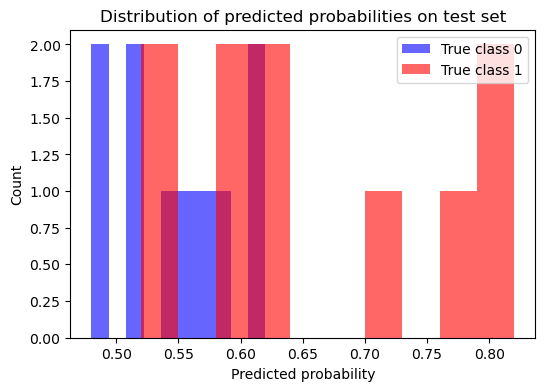

In [26]:
fig, ax = plt.subplots(figsize=(6,4))

ax.hist(
    test_preds[test_labels == 0],
    bins=10, alpha=0.6, label="True class 0", color="blue"
)
ax.hist(
    test_preds[test_labels == 1],
    bins=10, alpha=0.6, label="True class 1", color="red"
)

ax.set_xlabel("Predicted probability")
ax.set_ylabel("Count")
ax.set_title("Distribution of predicted probabilities on test set")
ax.legend()

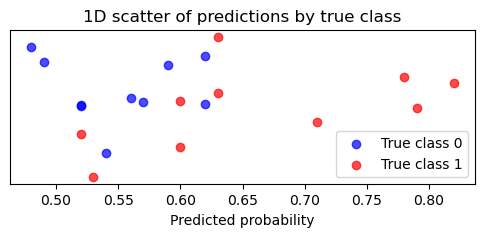

In [27]:
fig, ax = plt.subplots(figsize=(6,2))

# Jitter y positions a bit to separate points
y0 = rng.normal(0, 0.02, size=sum(test_labels==0))
y1 = rng.normal(0, 0.02, size=sum(test_labels==1))

ax.scatter(test_preds[test_labels == 0], y0, alpha=0.7, label="True class 0", color="blue")
ax.scatter(test_preds[test_labels == 1], y1, alpha=0.7, label="True class 1", color="red")

ax.set_xlabel("Predicted probability")
ax.set_yticks([])
ax.set_title("1D scatter of predictions by true class")
ax.legend()

Text(0.5, 1.0, 'Training Loss Curve')

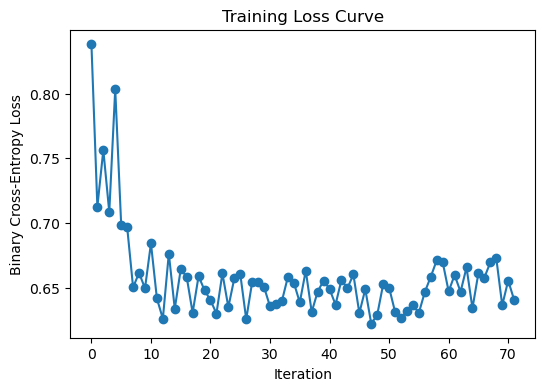

In [28]:
# %%
# Plot training loss curve
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(loss_log, marker="o")
ax.set_xlabel("Iteration")
ax.set_ylabel("Binary Cross-Entropy Loss")
ax.set_title("Training Loss Curve")

In [31]:
def train(X, Y, model, args):
    #X, Y are datasets, model is from torch.nn,
    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)
    # tensors are multi dimensional matrix of a single data type. this is intialized
    #as a matrix of 32 bit floats. 
    N = len(Y)

    optimizer = optim.SGD(model.parameters(), lr=args.lr)
    # SGD = stochastic gradient descent -> instead of iterating over all the data, uses 1 point or small set to 
    #make computations faster on large datasets. 
    #lr = learning rate

    model.train()
    #turns on training mode for the module
    for epoch in range(args.epoch):
        perm = torch.randperm(N)
        #returns a random permutations of numbers from 0 to N-1
        sum_loss = 0

        for i in range(0, N, args.batchsize):
            #going from 0 to N in steps of the batchsize. 
            x = X[perm[i : i + args.batchsize]].to(args.device) 
                #takes a vector from the tensor and sends it to the device
            y = Y[perm[i : i + args.batchsize]].to(args.device)

            optimizer.zero_grad() #resets the gradients
            output = model(x).squeeze()
            #since the model is a linear transformation, model(x) is a tensor again.
            #this removes all dimensions of size 1 from the tensor
            weight = model.weight.squeeze()
            #model.weight is also a tensor of learnable weights

            loss = torch.mean(torch.clamp(1 - y * output, min=0))
            #calculating the loss
            loss += args.c * (weight.t() @ weight) / 2.0

            loss.backward()
            optimizer.step()

            sum_loss += float(loss)
            #summing the loss over all i

        print("Epoch: {:4d}\tloss: {}".format(epoch, sum_loss / N))


def visualize(X, Y, model):
    W = model.weight.squeeze().detach().cpu().numpy()
    b = model.bias.squeeze().detach().cpu().numpy()

    delta = 0.001
    x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
    y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
    x, y = np.meshgrid(x, y)
    xy = list(map(np.ravel, [x, y]))

    z = (W.dot(xy) + b).reshape(x.shape)
    z[np.where(z > 1.0)] = 4
    z[np.where((z > 0.0) & (z <= 1.0))] = 3
    z[np.where((z > -1.0) & (z <= 0.0))] = 2
    z[np.where(z <= -1.0)] = 1

    plt.figure(figsize=(10, 10))
    plt.xlim([X[:, 0].min() + delta, X[:, 0].max() - delta])
    plt.ylim([X[:, 1].min() + delta, X[:, 1].max() - delta])
    plt.contourf(x, y, z, alpha=0.8, cmap="Greys")
    plt.scatter(x=X[:, 0], y=X[:, 1], c="black", s=10)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    parser = argparse.ArgumentParser() #initialize the args
    parser.add_argument("--c", type=float, default=0.01)
    parser.add_argument("--lr", type=float, default=0.1) #learning rate
    parser.add_argument("--batchsize", type=int, default=5)
    parser.add_argument("--epoch", type=int, default=10)
    parser.add_argument("--device", default="cuda", choices=["cpu", "cuda"])
    args = parser.parse_args([])
    args.device = torch.device(args.device if torch.cuda.is_available() else "cpu")

    print(args)

NameError: name 'argparse' is not defined